In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from plotting_functions import nn_plot_epoch_acc
from enkf_functions import enkf_classifier
from saving_functions import load_objects
from model_functions import nn_load
import reproducible
import no_gpu

In [4]:
X_train, X_val, y_train, y_val = mnist_prep()

In [5]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

In [6]:
X_train = X_train_small
X_test = X_val_small
y_train = y_train_small
y_test = y_val_small

In [7]:
layers = 5
neurons = [128, 128, 64, 32, 10]

In [8]:
setting_dict = {"particles": 10,
                "epochs": 10,
                "batch_size": 50,    # len(X_train)
                "h_0": 2,
                "delta": 0.005,
                "epsilon": 0.5,
                "randomization": False,
                "shuffle": True,
                "early_stopping": False,
                "early_stopping_diff": 0.001
               }

In [9]:
import time
start_time = time.time()

In [10]:
mean_model, mean_model_train_acc, mean_model_test_acc = enkf_classifier(X_train,
                                                                        X_test,
                                                                        y_train,
                                                                        y_test,
                                                                        layers,
                                                                        neurons,
                                                                        setting_dict,
                                                                        save_all = True,
                                                                        file_var = "../objects/mnist/enkf_mnist_E{}_B{}_P{}_H{}.pckl".format(setting_dict["epochs"], setting_dict["batch_size"], setting_dict["particles"], setting_dict["h_0"]),
                                                                        file_model = "../models/mnist/enkf_mnist_E{}_B{}_P{}_H{}.h5".format(setting_dict["epochs"], setting_dict["batch_size"], setting_dict["particles"], setting_dict["h_0"]),
                                                                        verbose = 0)

In [11]:
end_time = time.time()
print("Calculation time: {} minutes.".format((end_time - start_time) / 60))

Calculation time: 1.0162574092547099 minutes.


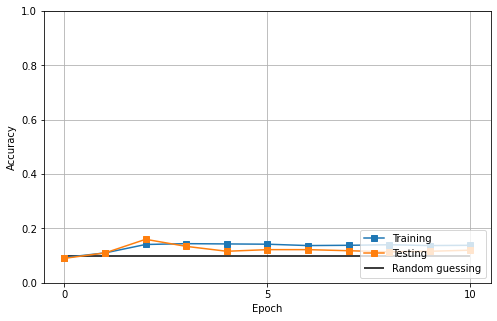

In [12]:
nn_plot_epoch_acc(mean_model_train_acc,
                  mean_model_test_acc,
                  mean_comparison = 0.1,
                  savefig = False,
                  file = "../img/mnist/enkf_mnist_E{}_B{}_P{}_H{}.png".format(setting_dict["epochs"], setting_dict["batch_size"], setting_dict["particles"], setting_dict["h_0"]))

In [13]:
obj_dict = load_objects("../objects/mnist/enkf_mnist_E{}_B{}_P{}_H{}.pckl".format(setting_dict["epochs"], setting_dict["batch_size"], setting_dict["particles"], setting_dict["h_0"]))

In [14]:
final_model = nn_load("../models/mnist/enkf_mnist_E{}_B{}_P{}_H{}.h5".format(setting_dict["epochs"], setting_dict["batch_size"], setting_dict["particles"], setting_dict["h_0"]))